## Imports and Constants

$$
\newcommand{\abs}[1]{\left\lvert#1\right\rvert}  % absolute value
\newcommand{\C}{\mathbb{C}}  % complex numbers
\newcommand{\ceil}[1]{\left\lceil #1 \right\rceil}  % ceiling
\newcommand{\closure}{\operatorname{cl}}  % distance
\newcommand{\conv}{\operatorname{conv}}  % convex hull
\newcommand{\cov}{\operatorname{Cov}}  % covariance
\newcommand{\diag}{\operatorname{diag}}  % diagonal
\newcommand{\dist}{\operatorname{dist}}  % distance
\newcommand{\dom}{\operatorname{dom}}  % domain
\newcommand{\E}{\mathbb{E}}  % expectation
\newcommand{\epi}{\operatorname{epi}}  % epigraph
\newcommand{\extreme}{\operatorname{extreme}}  % extreme point
\newcommand{\floor}[1]{\left\lfloor #1 \right\rfloor}  % floor
\newcommand{\inner}[2]{\left\langle#1,\ #2\right\rangle}  % inner product
\newcommand{\interior}{\operatorname{int}}  % interior
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}  % norm
\newcommand{\nullspace}{\operatorname{Null}}  % nullspace
\newcommand{\one}{\mathbf{1}}  % ones vector
\newcommand{\Proj}{\mathcal{P}}  % projection
\newcommand{\range}{\operatorname{Range}}  % range
\newcommand{\rank}{\operatorname{rank}}  % rank
\newcommand{\set}[1]{\left\{#1\right\}}  % set
\newcommand{\spanset}{\operatorname{span}}  % span
\newcommand{\Sym}{\mathbb{S}}  % symmetric, real matrices
\newcommand{\tr}{\operatorname{tr}}  % trace
\newcommand{\var}{\operatorname{Var}}  % variance
\newcommand{\zero}{\mathbf{0}}  % ones vector
\renewcommand{\N}{\mathbb{N}}  % natural numbers
\renewcommand{\R}{\mathbb{R}}  % real numbers
\renewcommand{\Z}{\mathbb{Z}}  % integers
\newcommand{\vpar}{v^\text{par}}
\newcommand{\vnom}{v^\text{nom}}
\newcommand{\vmid}{v^\text{mid}}
\newcommand{\vmin}{\underline{v}}
\newcommand{\vmax}{\overline{v}}
\newcommand{\qmin}{\underline{q}}
\newcommand{\qmax}{\overline{q}}
\newcommand{\qlims}{[\qmin, \qmax]}
\newcommand{\vlims}{[\vmin, \vmax]}
$$

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib widget

In [2]:
from __future__ import annotations

from collections.abc import Sequence
import csv
import time
from typing import Any, TypeVar

import cvxpy as cp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.plotting
import scipy.io
from tqdm.auto import tqdm

from cbc import CBCProjection
from network_utils import (
    create_56bus,
    create_R_X_from_net,
    calc_voltage_profile
)
from robust_voltage_control import (
    VoltPlot,
    robust_voltage_control
)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

# hide top and right splines on plots
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

/tmp/ipykernel_5982/1375556576.py:30: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [3]:
time_ticks =  [0      ,    2400,    4800,    7200,    9600,   12000,   14400]
time_labels = ['00:00', '04:00', '08:00', '12:00', '16:00', '20:00', '24:00']

rng = np.random.default_rng()

## Setup

Data (TODO: check units)
- $r$, $x$: resistance, in ohms
- $p$: active power injection, in MW
- $q$: reactive power injection, in MVar

The nominal voltage is 12kV.

We know that $P = I V = V^2 / R$. In units, we have
$$ W = V^2 / R $$
$$ MW = (kV)^2 / R $$

In [4]:
net = create_56bus()
R, X = create_R_X_from_net(net)

# fig, ax = plt.subplots(1,1)
# pp.plotting.simple_plot(net, ax=ax)
# plt.show()

$$w = \underbrace{R (p_t - p_{t-1})}_{w^p} + \underbrace{X (q_t - q_{t-1})}_{w^q}$$

In [6]:
def read_load_data() -> tuple[np.array, np.array]:
    """Read in load data.

    Returns
    - p: np.array, shape [n, T], active load in MW, TODO sign
    - q: np.array, shape [n, T], reactive load in MVar, TODO sign
    """
    mat = scipy.io.loadmat('data/pq_fluc.mat', squeeze_me=True)
    pq_fluc = mat['pq_fluc']  # shape (55, 2, 14421)
    p = pq_fluc[:, 0]  # active load, shape (55, 14421)
    qe = pq_fluc[:, 1]  # reactive load
    return p, qe

def smooth(x: np.ndarray, w: int = 5) -> np.ndarray:
    """Smooths input using moving-average window.

    Edge values are preserved as-is without smoothing.

    Args
    - x: np.array, shape [T] or [n, T]
    - w: int, moving average window, odd positive integer

    Returns: np.array, same shape as x, smoothed
    """
    assert w % 2 == 1
    edge = w // 2

    x_smooth = x.copy()
    ones = np.ones(w)
    if len(x.shape) == 1:
        x_smooth[edge:-edge] = np.convolve(x, ones, 'valid') / w
    elif len(x.shape) == 2:
        for i in range(len(x)):
            x_smooth[i, edge:-edge] = np.convolve(x[i], ones, 'valid') / w
    else:
        raise ValueError('smooth() only works on 1D or 2D arrays')
    return x_smooth

def calc_max_norm_w(R, X, p, qe):
    """Calculates ||w||_∞.

    Args
    - R: shape [n, n]
    - X: shape [n, n]
    - p: shape [n, T], active power load
    - qe: shape [n, T], exogenous reactive load

    Returns
    - norms: dict, keys are ['w', 'wp', 'wq']
    - max_p_idx: int, bus index with largest ||w_p||
    - max_q_idx: int, bus index with largest ||w_q||
    """
    wp = R @ (p[:, 1:] - p[:, :-1])
    wq = X @ (qe[:, 1:] - qe[:, :-1])
    w = wp + wq
    norms = {
        'w':  np.linalg.norm( w, ord=np.inf, axis=0),
        'wp': np.linalg.norm(wp, ord=np.inf, axis=0),
        'wq': np.linalg.norm(wq, ord=np.inf, axis=0)
    }
    max_p_idx = np.argmax(np.max(np.abs(wp), axis=1))
    max_q_idx = np.argmax(np.max(np.abs(wq), axis=1))
    return norms, max_p_idx, max_q_idx

In [7]:
p, qe = read_load_data()  # in MW and MVar (TODO: confirm units)

## Consider smoothing the data

In [ ]:
def plot_w_norms(norms, title):
    fig, axs = plt.subplots(1, 3, figsize=(10, 2), sharey=True, tight_layout=True)
    axs[0].hist(norms['w'], bins=200)
    axs[0].set(xlabel='$||w||_\infty$', ylabel='count', yscale='log')
    axs[1].hist(norms['wp'], bins=200)
    axs[1].set(xlabel='$||w^p||_\infty$')
    axs[2].hist(norms['wq'], bins=200)
    axs[2].set(xlabel='$||w^q||_\infty$')
    fig.suptitle(title)
    plt.show()

def plot_with_diff(axs, p, max_idx, ylabel, ylabel_diff):
    for i in range(len(p)):
        axs[0].plot(p[i])
    axs[0].set(xlabel='time $t$', ylabel=ylabel)
    axs[1].plot(np.diff(p[max_idx]), label=f'bus {max_idx}')
    axs[1].set(xlabel='time $t$', ylabel=ylabel_diff)
    axs[1].legend()

# before smoothing
norms, max_p_idx, max_q_idx = calc_max_norm_w(R, X, p, qe)
print(f'max_t ||w_t||_∞ = {norms["w"].max()}')

title = 'No smoothing'
fig, axs = plt.subplots(2, 2, figsize=(10, 4), sharex=True, tight_layout=True, gridspec_kw={'height_ratios': [2, 1]})
plot_with_diff(axs[:, 0], p, max_idx=max_p_idx, ylabel='active power (MW)', ylabel_diff='$p_{t+1} - p_t$')
plot_with_diff(axs[:, 1], qe, max_idx=max_q_idx, ylabel='reactive power (MVar)', ylabel_diff='$q^e_{t+1} - q^e_t$ (MVar)')
fig.suptitle(title)
plot_w_norms(norms, title)

## Voltage Control with Known Line Parameters

If the line parameters $X$ are known, then we can directly apply our 1-step controller.

We define
- $\vlims = [0.95 \mathrm{pu}, 1.05 \mathrm{pu}] = [(11.4 \mathrm{kV})^2, (12.6 \mathrm{kV})^2]$
- $\qlims = TODO$

### Assuming linear system dynamics

In this section, we assume the Simplified DistFlow linear model.

$$
\begin{aligned}
    v(t+1)
    &= v(t) + X u(t) + w(t) \\
    &= X[q^c(t) + q^e(t)] + Rp(t) + v^0 \one
\end{aligned}
$$

<!-- In a sense, we could let $v(0) = X q^e(t) + R p(t)$ with $q^c(-1) = \zero$, then
$$
    v(1) = v(0) + X u(t) + w(0)
$$ -->

In [ ]:
# given data
n, T = qe.shape
print("exogenous reactive power injection:", qe.shape)
print("active power injection:", p.shape)
print()

# bounds
# - see Qu and Li, 2020
constrained_buses = np.array([18, 21, 30, 45, 53]) - 1  # -1 for 0-indexing
q_min, q_max = (-.2 , .2)   # MVar
v_min, v_max = (11.4**2, 12.6**2)  # +/-5%, units kV^2

# initial conditions
vnom = 12  # nominal voltage magnitude, units kV
qc0 = np.zeros(n)

# v1 = rng.uniform((0.97 * vnom)**2, (0.98 * vnom)**2, size=[n])  # initial squared voltage magnitude, units kV^2

First, we check that Assumption 2 is actually satisfied:

For some known $\epsilon \geq 0$, the noise sequence $\{w(t)\}_t$, line parameters $X$, voltage limits $\vlims$, reactive power injection limits $\qlims$, and recovery time $T_r \geq 2$ satisfy

$$
\begin{aligned}
& \forall t \geq T_r - 1.\ \exists u \in \mathcal{U}(t) \text{ s.t. }\\
& \quad v(t)+Xu \in [\vmin + (\eta + \epsilon) \one,\ \vmax - (\eta + \epsilon) \one] \\
& \text{where } \mathcal{U}(t):=\{u \in \R^n: \qmin \leq q^c(t-1)+u \leq \qmax \}
\end{aligned}
$$

Note that $u = q^c_t - q^c(t-1)$, so
$$
\begin{aligned}
v(t)
    &= X[q^c(t-1) + q^e(t-1)] + Rp(t-1) + v^0 \one \\
Xu
    &= X[q^c_t - q^c(t-1)] \\
v(t) + Xu
    &= X[q^c_t + q^e(t-1)] + Rp(t-1) + v^0 \one.
\end{aligned}
$$

Therefore, an equivalent assumption is:
$$
\begin{aligned}
& \forall t \geq T_r - 1.\ \exists q^c_t \in \qlims \text{ s.t. } \\
& \quad X[q^c_t + q^e(t-1)] + Rp(t-1) + v^0 \one \in [\vmin + (\eta + \epsilon) \one,\ \vmax - (\eta + \epsilon) \one]
\end{aligned}
$$

In [ ]:
def calc_qlims(
        p: np.ndarray, qe: np.ndarray,
        v_lims: tuple[Any, Any],
        X: np.ndarray, R: np.ndarray,
        eta: float, eps: float, Tr: int, v_sub: float) -> np.ndarray:
    """Calculates minimum-inf-norm values for q^c_t to ensure feasibility.

    Args
    - p: np.array, shape [n, T], active power injection (MW)
    - qe: np.array, shape [n, T], exogenous reactive power injection (MVar)
    - v_lims: tuple (v_min, v_max), squared voltage magnitude limits (kV^2)
        - v_min, v_max could be floats, or np.arrays of shape [n]
    - X: np.array, shape [n, n], line parameters for reactive power injection
    - R: np.array, shape [n, n], line parameters for active power injection
    - eta: float, noise bound (kV^2)
    - eps: float, robustness buffer (kV^2)
    - Tr: int, recovery time, >= 2
    - v_sub: float, fixed squared voltage magnitude at substation (kV^2)

    Returns
    - qcts: np.ndarray, shape [n, T-1]
    """
    assert p.shape == qe.shape
    n, T = qe.shape

    v_min, v_max = v_lims
    if isinstance(v_min, float):
        v_min = v_min * np.ones(n)
        v_max = v_max * np.ones(n)

    v_lb = v_min + eta + eps
    v_ub = v_max - (eta + eps)
    qcts = []

    # ============================================================
    # slower version: optimize qct one time step at a time
    # ============================================================
    # qct = cp.Variable(n)
    # obj = cp.Minimize(cp.norm(qct, p='inf'))

    # qe_t = cp.Parameter(n)
    # p_t = cp.Parameter(n)

    # vt = v_sub + X @ (qct + qe_t) + R @ p_t
    # constraints = [v_lb <= vt, vt <= v_ub]
    # prob = cp.Problem(objective=obj, constraints=constraints)
    # assert prob.is_dcp(dpp=True)

    # for t in tqdm(range(Tr-1, T)):
    #     qe_t.value = qe[:, t-1]
    #     p_t.value = p[:, t-1]
    #     prob.solve()
    #     assert prob.status == 'optimal'
    #     qcts.append(np.array(qct.value))  # make a copy
    # qcts = np.stack(qcts, axis=1)

    # ============================================================
    # faster version: optimize qct mulitple time steps at once
    # ============================================================
    v_lb = v_lb.reshape(n, 1)
    v_ub = v_ub.reshape(n, 1)

    block = 64
    qct = cp.Variable([n, block])
    obj = cp.Minimize(cp.sum(cp.norm(qct, p='inf', axis=0)))

    qe_t = cp.Parameter([n, block])
    p_t = cp.Parameter([n, block])
    vt = v_sub + X @ (qct + qe_t) + R @ p_t
    constraints = [v_lb <= vt, vt <= v_ub]
    prob = cp.Problem(objective=obj, constraints=constraints)

    for t in tqdm(range(Tr-1, T, block)):
        if t + block > T:
            cols = list(range(t-1, T)) + [T-1] * (block + t - T - 1)
        else:
            cols = slice(t-1, t-1+block)

        qe_t.value = qe[:, cols]
        p_t.value = p[:, cols]
        
        prob.solve()
        assert prob.status == 'optimal'
        qcts.append(np.array(qct.value))  # make a copy
    qcts = np.concatenate(qcts, axis=1)

    return qcts


def check_assumption_2(
        p: np.ndarray, qe: np.ndarray,
        q_lims: tuple[Any, Any], v_lims: tuple[Any, Any],
        X: np.ndarray, R: np.ndarray,
        eta: float, eps: float, Tr: int, v_sub: float) -> None:
    """Checks if the given q_lims are feasible.

    Args
    - p: np.array, shape [n, T], active power injection (MW)
    - qe: np.array, shape [n, T], exogenous reactive power injection (MVar)
    - q_lims: tuple (q_min, q_max), reactive power injection limits (MVar)
        - q_min, q_max could be floats, or np.arrays of shape [n]
    - v_lims: tuple (v_min, v_max), squared voltage magnitude limits (kV^2)
        - v_min, v_max could be floats, or np.arrays of shape [n]
    - X: np.array, shape [n, n], line parameters for reactive power injection
    - R: np.array, shape [n, n], line parameters for active power injection
    - eta: float, noise bound (kV^2)
    - eps: float, robustness buffer (kV^2)
    - Tr: int, recovery time
    - v_sub: float, fixed squared voltage magnitude at substation (kV^2)
    """
    assert p.shape == qe.shape
    n, T = qe.shape

    q_min, q_max = q_lims
    v_min, v_max = v_lims

    if isinstance(q_min, float):
        q_min = np.ones(n) * q_min
        q_max = np.ones(n) * q_max
    if isinstance(v_min, float):
        v_min = np.ones(n) * v_min
        v_max = np.ones(n) * v_max

    v_lb = v_min + eta + eps
    v_ub = v_max - (eta + eps)

    obj = cp.Minimize(1)

    # ============================================================
    # slow version: check feasibility one time step at a time
    # ============================================================
    # qct = cp.Variable(n)
    # base_constraints = [q_min <= qct, qct <= q_max]
    # for t in tqdm(range(Tr-1, T)):
    #     vt = v_sub + X @ (qct + qe[:, t-1]) + R @ p[:, t-1]
    #     constraints = base_constraints + [
    #         v_lb <= vt, vt <= v_ub,
    #     ]
    #     prob = cp.Problem(objective=obj, constraints=constraints)
    #     prob.solve()
    #     assert prob.status == 'optimal'

    # ============================================================
    # faster version: check feasibility in blocks
    # ============================================================
    v_lb = v_lb.reshape(n, 1) 
    v_ub = v_ub.reshape(n, 1)
    q_min = q_min.reshape(n, 1)
    q_max = q_max.reshape(n, 1)

    block = 50
    qct = cp.Variable([n, block])
    base_constraints = [q_min <= qct, qct <= q_max]
    for t in tqdm(range(Tr-1, T, block)):
        if t + block > T:
            block = T - t
            qct = cp.Variable([n, block])
            base_constraints = [q_min <= qct, qct <= q_max]

        vt_block = v_sub + X @ (qct + qe[:, t-1:t-1+block]) + R @ p[:, t-1:t-1+block]
        constraints = base_constraints + [
            v_lb <= vt_block, vt_block <= v_ub,
        ]
        prob = cp.Problem(objective=obj, constraints=constraints)
        prob.solve()
        assert prob.status == 'optimal'

In [ ]:
qcts = calc_qlims(
    p, qe, v_lims=(v_min, v_max),
    X=X, R=R, eta=0, eps=0, Tr=2, v_sub=12**2)

In [ ]:
print(f'min q_i: {np.min(qcts):.4f}, max q_i: {np.max(qcts):.4f}')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(np.linalg.norm(qcts, ord=np.inf, axis=0), label='$\|q\|_\infty$')
ax.plot(np.max(qcts, axis=0), label='$\max_i q_i$')
ax.plot(np.min(qcts, axis=0), label='$\min_i q_i$')
ax.legend()
plt.show()

In [ ]:
qcts = calc_qlims(
    p, qe, v_lims=(v_min, v_max),
    X=X, R=R, eta=8.63, eps=0.1, Tr=2, v_sub=12**2)

In [ ]:
print(f'min q_i: {np.min(qcts):.4f}, max q_i: {np.max(qcts):.4f}')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(np.linalg.norm(qcts, ord=np.inf, axis=0), label='$\|q\|_\infty$')
ax.plot(np.max(qcts, axis=0), label='$\max_i q_i$')
ax.plot(np.min(qcts, axis=0), label='$\min_i q_i$')
ax.legend()
plt.show()

TODO:
- decide which buses have controllable reactive power injection
- decide which buses to check for voltage violations


In [ ]:
check_assumption_2(
    p, qe, q_lims=(q_min, q_max), v_lims=(v_min, v_max),
    X=X, R=R, eta=0, eps=0, Tr=6500, v_sub=12**2)

In [ ]:
%debug

## Test NCBC projection algorithm

In [ ]:
n, T = qe.shape
q_min, q_max = (-.25 , .25)   # MVar

In [ ]:
# generate a random voltage trajectory
us = np.zeros_like(qe)
qcs = np.zeros_like(qe)
for t in range(T):
    # randomly sample a valid action u
    u_ub = q_max - qcs[:, t-1]
    u_lb = q_min - qcs[:, t-1]
    u = rng.random(n) * (u_ub - u_lb) + u_lb
    us[:, t] = u
    qcs[:, t] = qcs[:, t-1] + u

v_sq = calc_voltage_profile(X, R, p=p, qe=qe, qc=qcs, v_sub=12**2)

In [ ]:
diff = (v_sq[:, 1:] - v_sq[:, :-1]) - X @ us[:, 1:]
print(diff.max())
print(diff.min())

In [ ]:
n = v_sq.shape[0]
sel = CBCProjection(eta=0.7, n=n, v=v_sq[:, 0], T=v_sq.shape[1], sample=True, true_X=X)

In [ ]:
ts = [0]
dists_fro = []
dists_max = []

Xhat = sel.select()
prev_Xhat = Xhat
dists_fro.append(np.linalg.norm(Xhat - X, 'fro')**2)
dists_max.append(np.abs(Xhat - X).max())

In [ ]:
for t in tqdm(range(1, v_sq.shape[1])):
    sel.add_obs(v=v_sq[:, t], u=us[:, t])
    if t % 20 == 0:
        Xhat = sel.select()
        if prev_Xhat is not Xhat:
            dist_fro = np.linalg.norm(Xhat - X, 'fro')**2
            dist_max = np.abs(Xhat - X).max()
            tqdm.write(f't = {t:6d}, ||Xhat-X||_fro**2 = {dist_fro:7.1f}, _max = {dist_max:5.3f}')
            prev_Xhat = Xhat
        ts.append(t)
        dists_fro.append(dist_fro)
        dists_max.append(dist_max)

In [ ]:
%debug

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax1.plot(ts, dists_fro, label='$|| \hat{X} - X ||_F^2$')

color = 'tab:orange'
ax2 = ax1.twinx()
ax2.plot(ts, dists_max, label='$|| \hat{X} - X ||_\max$', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.legend(loc='upper center')

## Robust Voltage Control

For simplicity, we use the discrete-time system
$$
\begin{aligned}
v(t) &= X [q^c(t) + q^e(t)] + R p(t) + v^0 \one \\
u(t) &= q^c(t+1) - q^c(t) \\
q^c(0) &= \zero \\
w(t) &= X [q^e(t+1) - q^e(t)] + R[p(t+1) - p(t)] \\
v(t+1) &= v(t) + X u(t) + w(t)
\end{aligned}
$$
and we assume
$$
\begin{aligned}
& \forall t \geq T_r.\ \exists u \in \mathcal{U}(t) \text{ s.t. } \\
& \quad v(t) + X u \in [\vmin + (\eta + \epsilon)\one, \vmax - (\eta + \epsilon)\one] \\
& \text{where } \mathcal{U}(t) := \{u \in \R^n:\ \qmin \leq q^c(t) + u \leq \qmax\}
\end{aligned}
$$

### Case 1: Default network

- no smoothing: $\eta = 8.7$
- under-powered reactive power injection: $[\qmin, \qmax] = [-0.2, 0.2]$

In [8]:
n, T = p.shape

eta = 8.7
epsilon = 0.1
q_min, q_max = (-0.2, 0.2)
v_min, v_max = (11.4**2, 12.6**2)  # +/-5%, units kV^2
v_nom = 12**2  # nominal squared voltage magnitude, units kV^2
v_sub = v_nom  # fixed squared voltage magnitude at substation, units kV^2

v_init = X @ qe[:,0] + R @ p[:,0] + v_sub

Pv = 0.1 * np.eye(n)
Pu = 10 * np.eye(n)

# weights on slack variables: alpha for CBC, beta for robust oracle
alpha = 50
beta = 10

widget? True


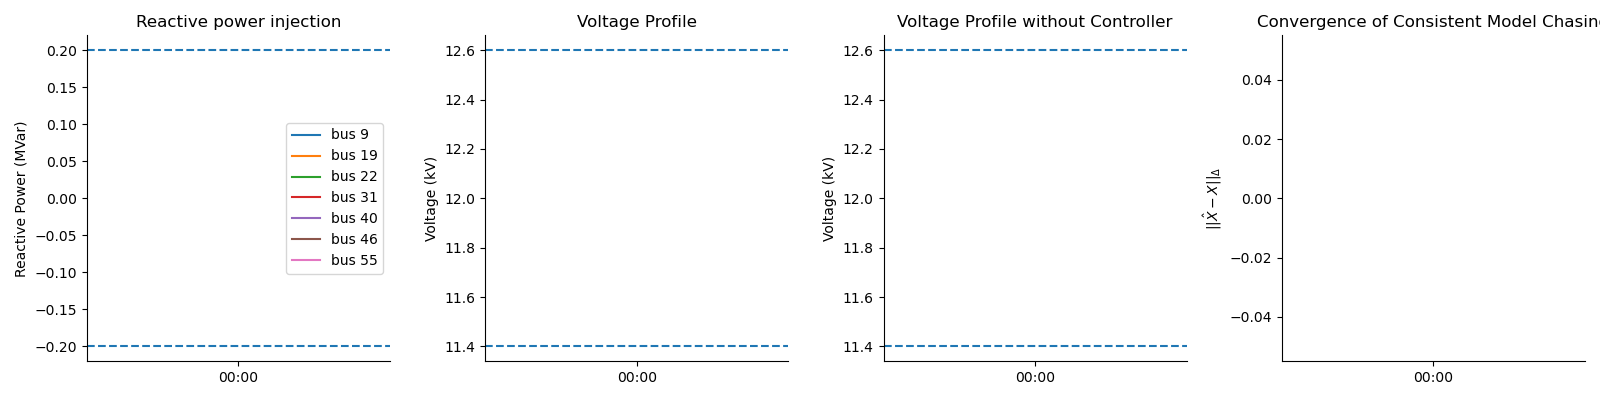

In [9]:
volt_plot = VoltPlot(v_lims=(np.sqrt(v_min), np.sqrt(v_max)), q_lims=(q_min, q_max))

In [10]:
sel = CBCProjection(eta=eta, n=n, T=T, n_samples=20, alpha=alpha,
                    v=v_init, X_true=X, X_init=np.eye(n))

vs, qcs = robust_voltage_control(
    p=p, qe=qe, v_lims=(v_min, v_max), q_lims=(q_min, q_max), v_nom=v_nom,
    X=X, R=R, Pv=Pv, Pu=Pu, eta=eta, eps=epsilon, v_sub=v_sub, beta=beta,
    sel=sel, volt_plot=volt_plot)

rho(eps=0.10) = 0.017
CBC prob is DPP?: True


  0%|          | 0/14420 [00:00<?, ?it/s]

t =      0, ||Xhat-X||_△ =   164.8, ||Xhat-Xhat_prev||_△ = 0.000
est_noise: 1.596
est_noise: 1.760
est_noise: 3.972
est_noise: 10.207
not lazy
----------------------------------------------------------------------------
	SCS v2.1.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 31791
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 1541, constraints m = 8031
Cones:	linear vars: 3465
	soc vars: 3026, soc blks: 1
	sd vars: 1540, sd blks: 1
Setup time: 5.09e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.94e+21  1.00e+20  1.00e+00 -3.91e+23 -1.44e+19  1.97e+24  5.10e-02 


SolverError: Solver 'SCS' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
volt_plot = VoltPlot(v_lims=(np.sqrt(v_min), np.sqrt(v_max)), q_lims=(q_min, q_max))

In [ ]:
sel = CBCProjection(eta=eta, n=n, T=T, n_samples=20, alpha=alpha,
                    v=v_init, X_true=X, X_init=np.ones([n,n]))

vs, qcs = robust_voltage_control(
    p=p, qe=qe, v_lims=(v_min, v_max), q_lims=(q_min, q_max), v_nom=v_nom,
    X=X, R=R, Pv=Pv, Pu=Pu, eta=eta, eps=epsilon, v_sub=v_sub, beta=beta,
    sel=sel, volt_plot=volt_plot)

In [ ]:
volt_plot = VoltPlot(v_lims=(np.sqrt(v_min), np.sqrt(v_max)), q_lims=(q_min, q_max))

In [ ]:
vs, qcs = robust_voltage_control(
    p=p, qe=qe, v_lims=(v_min, v_max), q_lims=(q_min, q_max), v_nom=v_nom,
    X=X, R=R, Pv=Pv, Pu=Pu, eta=eta, eps=epsilon, v_sub=v_sub, volt_plot=volt_plot)

In [ ]:
%debug

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))

In [ ]:
import time
for i in range(100):
    ax.plot(range(i,2*i), range(i))
    fig.canvas.draw()
    time.sleep(0.2)

In [ ]:
tqdm.write('3')
IPython.display.clear_output()
tqdm.write('4')

In [ ]:
%matplotlib widget

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(5))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))

In [ ]:
ax.plot(range(10))

In [ ]:
from ipywidgets import Button
Button(description='test')

In [ ]:
import matplotlib
matplotlib.__version__